In [347]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
import statsmodels.api as sm 
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [5]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [6]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [7]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
nii_bo_dir = '../../data/niis'

In [9]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [10]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [11]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [12]:
ddir = '../../data/'

In [13]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [14]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [15]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [16]:
template = se.helpers._gray(res=2)

In [17]:
factors=700

In [18]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [19]:
pieman_data = loadmat(pieman_name)

In [20]:
debug = False

In [21]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [22]:
data = np.array(data)
conds = np.array(conds)

## pieman pca decoding

In [501]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

In [502]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [503]:
conds

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/intact.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/paragraph.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/rest.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/word.csv']

In [504]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [505]:
full_data.head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.805733,0.003333,0.488089,1,0,0,intact
1,0,0.709222,0.013333,0.329000,2,0,0,intact
2,0,0.726200,0.013333,0.309211,3,0,0,intact
3,0,0.816556,0.040000,0.258333,4,0,0,intact
4,0,0.869389,0.066667,0.241333,5,0,0,intact


In [469]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.805733,0.003333,0.488089,1,0,0,intact
1,0,0.709222,0.013333,0.329000,2,0,0,intact
2,0,0.726200,0.013333,0.309211,3,0,0,intact
3,0,0.816556,0.040000,0.258333,4,0,0,intact
4,0,0.869389,0.066667,0.241333,5,0,0,intact


In [420]:
outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

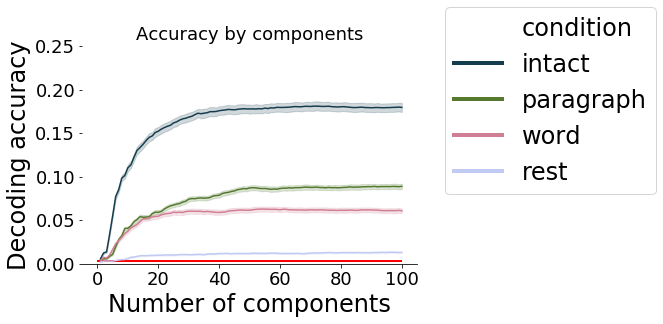

In [50]:
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .25)
ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [470]:
def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )

In [471]:
hill = []
maxs = []
spearmans = []

ydata = full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
xdata = np.array(full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

popt, pcov = curve_fit(func, xdata, ydata)
hill.append(popt[1])

max_i = ydata.max()
maxs.append(max_i)

max_loc = np.where(ydata==max_i)[0][0]

max_p = full_data[full_data['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
max_w = full_data[full_data['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
max_r = full_data[full_data['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


spearmans.append(spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0])


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


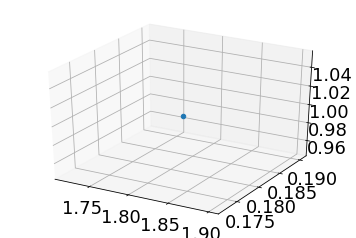

In [472]:
fig= plt.figure()
ax= fig.add_subplot(111, projection= '3d')
ax.scatter(hill,maxs,spearmans)

In [506]:
hill_all = np.zeros((4, 1, 4))
maxs_all = np.zeros((4, 1, 4))


In [507]:
conditions = ['intact', 'paragraph', 'word', 'rest']

for e, c in enumerate(conditions):
    
    ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)
    
    hill_all[e, 0, 0] = popt[1]
    
    maxs_all[e, 0, 0] = ydata.max()


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


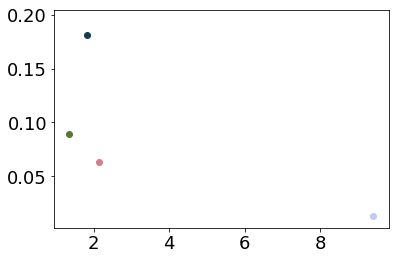

In [508]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    plt.scatter(hill_all[e, :, 0],maxs_all[e, :, 0], 
                color=colors[e])

#markers=['o', '$1$', '$2$','$3$']
# for n in np.arange(len(network_list)):
#     for i in np.arange(4):
    
#         plt.scatter(hill_all[n, i],maxs_all[n, i], 
#                    marker=markers[i], s=100, color=color_stacked[n])


In [509]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_chunked/PCA/ndims_100'

In [510]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [511]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [512]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0,0.7835,0.01,0.4538,1,0,0,0,intact
1,0,0.7149,0.03,0.3370,2,0,0,0,intact
2,0,0.7091,0.03,0.2867,3,0,0,0,intact
3,0,0.7379,0.04,0.2297,4,0,0,0,intact
4,0,0.8162,0.07,0.1967,5,0,0,0,intact


KeyboardInterrupt: 

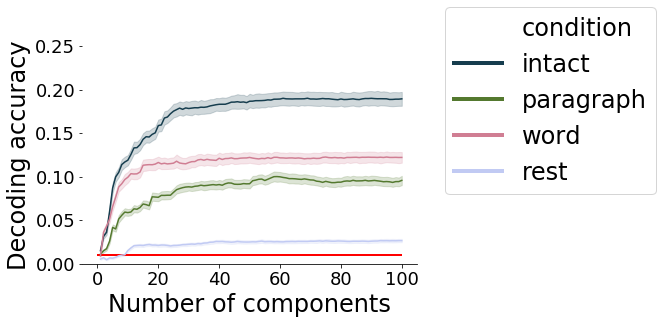

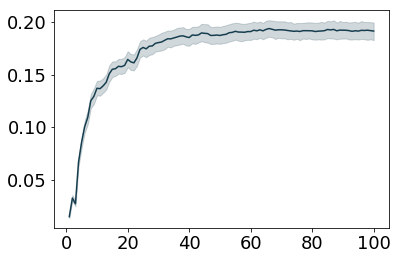

In [497]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')
    

In [513]:
conditions = ['intact', 'paragraph', 'word', 'rest']

for i in np.arange(1, 4):
    
    full_data_temp = full_data[full_data['third']==i-1]

    for e, c in enumerate(conditions):


        ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)

        hill_all[e, 0, i] = popt[1]

        maxs_all[e, 0, i] = ydata.max()


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [528]:
try_it = maxs_all/hill_all

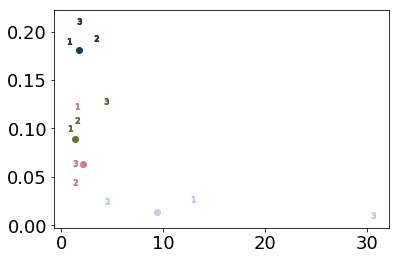

In [529]:
fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(hill_all[e, :, i],maxs_all[e, :, i], 
                    marker=markers[i], color=colors[e])

#markers=['o', '$1$', '$2$','$3$']
# for n in np.arange(len(network_list)):
#     for i in np.arange(4):
    
#         plt.scatter(hill_all[n, i],maxs_all[n, i], 
#                    marker=markers[i], s=100, color=color_stacked[n])


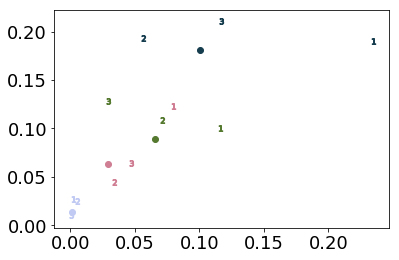

In [530]:
fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(try_it[e, :, i],maxs_all[e, :, i], 
                    marker=markers[i], color=colors[e])

#markers=['o', '$1$', '$2$','$3$']
# for n in np.arange(len(network_list)):
#     for i in np.arange(4):
    
#         plt.scatter(hill_all[n, i],maxs_all[n, i], 
#                    marker=markers[i], s=100, color=color_stacked[n])


In [428]:
# hill = []
# maxs = []
# spearmans = []

for i in range(3):
    full_data_temp = full_data[full_data['third']==i]

    ydata = full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata)
    hill.append(popt[1])
    max_i = ydata.max()
    print(maxs)
    maxs.append(max_i)
    max_loc = np.where(ydata==max_i)[0][0]

    max_p = full_data_temp[full_data_temp['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_w = full_data_temp[full_data_temp['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_r = full_data_temp[full_data_temp['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


    spearmans.append(spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0])


[0.18125]
[0.18125, 0.19034999999999996]
[0.18125, 0.19034999999999996, 0.19385000000000008]


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [429]:
maxs

[0.18125, 0.19034999999999996, 0.19385000000000008, 0.21135000000000012]

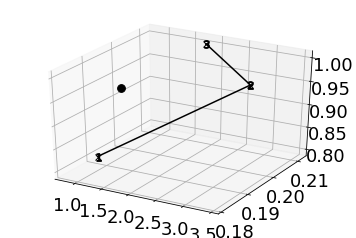

In [456]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
markers=['o', '$1$', '$2$','$3$']

ax.plot(hill[1:],maxs[1:],spearmans[1:],'x-', color='black')

for e, m in enumerate(markers):
    
    ax.scatter(hill[e],maxs[e],spearmans[e], marker=m, s=60, color='black')


In [457]:
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

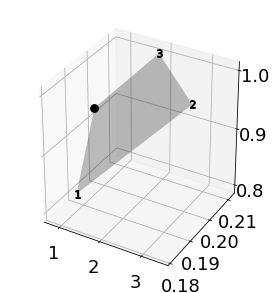

In [463]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(10,5))

custom=plt.subplot(121,projection='3d')

#custom.plot(hill[1:],maxs[1:],spearmans[1:],'x-', color='black')

for e, m in enumerate(markers):
    
    custom.scatter(hill[e],maxs[e],spearmans[e], marker=m, s=60, color='black')
    

#custom.scatter(hill, maxs, spearmans)
# 1. create vertices from points
verts = [list(zip(hill, maxs, spearmans))]
# 2. create 3d polygons and specify parameters
srf = Poly3DCollection(verts, alpha=.25, facecolor='black')
# 3. add polygon to the figure (current axes)
plt.gca().add_collection3d(srf)

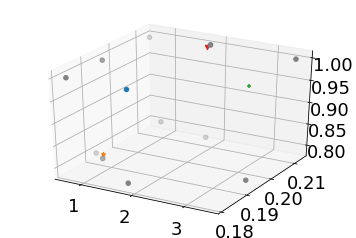

In [438]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
markers=['o', '*', '+','v']

for e, m in enumerate(markers):
    
    ax.scatter(hill[e],maxs[e],spearmans[e], marker=m)
    
xflat = np.full_like(hill, min(ax.get_xlim()))
yflat = np.full_like(maxs, max(ax.get_ylim()))
zflat = np.full_like(spearmans, min(ax.get_zlim()))

ax.scatter(xflat, maxs, spearmans, color='gray')
ax.scatter(hill, yflat, spearmans, color='gray')
ax.scatter(hill, maxs, zflat, color='gray')

In [39]:
data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()

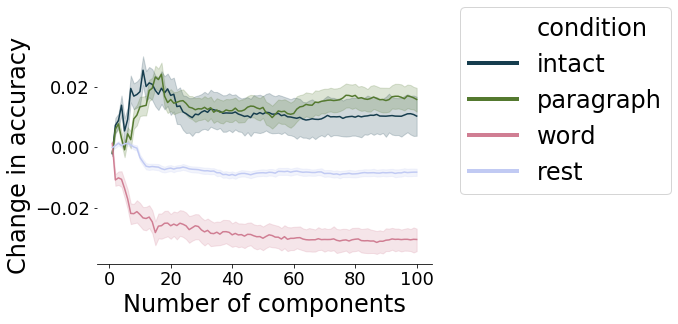

In [40]:
outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

fig, ax = plt.subplots()
sns.lineplot(x="dims", y="third",
             hue="condition",
             data=data_regression, palette="cubehelix", 
           hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components for third: ' + str(i + 1))
ax.set_ylabel('Change in accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)

l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')